In [197]:
from vit_pytorch.recorder import Recorder
from vit_pytorch import ViT
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
from scripts.model import *
from vit_pytorch.recorder import Recorder

In [198]:
img_dir = 'casting_data'
annotations_file = 'casting_data/annotations.csv'

BATCH_SIZE = 32
num_epochs = 8

ds_train = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='train')
ds_test = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='test')
  
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [199]:
image_size = 256
patch_size = 32
num_classes = 2
dim = 4
depth = 4
heads = 4
mlp_dim = 128
dropout = 0.01
emb_dropout = 0.01
 
model_config = {
  'image_size' : image_size,
  'patch_size' : patch_size,
  'num_classes' : num_classes,
  'dim' : dim,
  'depth' : depth,
  'heads' : heads,
  'mlp_dim' : mlp_dim,
  'dropout' : dropout,
  'emb_dropout' : emb_dropout
  }
 
model = ViT(image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = mlp_dim,
            dropout = dropout,
            emb_dropout = emb_dropout)

In [200]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
 
results = train(model=model,
                train_dataloader=dl_train,
                test_dataloader=dl_test,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device='cpu')

39814


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6854 | train_acc: 0.5673 | test_loss: 0.6588 | test_acc: 0.6155
Epoch: 2 | train_loss: 0.6682 | train_acc: 0.5876 | test_loss: 0.6800 | test_acc: 0.5698
Epoch: 3 | train_loss: 0.6388 | train_acc: 0.6381 | test_loss: 0.5806 | test_acc: 0.6953
Epoch: 4 | train_loss: 0.5873 | train_acc: 0.6936 | test_loss: 0.5418 | test_acc: 0.7222
Epoch: 5 | train_loss: 0.5506 | train_acc: 0.7217 | test_loss: 0.5398 | test_acc: 0.7257
Epoch: 6 | train_loss: 0.5178 | train_acc: 0.7504 | test_loss: 0.4898 | test_acc: 0.7628
Epoch: 7 | train_loss: 0.4772 | train_acc: 0.7712 | test_loss: 0.5044 | test_acc: 0.7719
Epoch: 8 | train_loss: 0.4853 | train_acc: 0.7666 | test_loss: 0.4990 | test_acc: 0.7759


In [201]:
model = Recorder(model)

In [273]:
img_idx = 66
img = dl_test.dataset.__getitem__(img_idx)[0]
img = img.reshape(1, 3, image_size, image_size)
preds, attns = model(img)
dl_test.dataset.__getitem__(img_idx)[1]

1

In [274]:
attns.shape

torch.Size([1, 4, 4, 65, 65])

In [275]:
last_layer = attns.sum(axis=0).sum(axis=0).sum(axis=0)
last_layer.shape

torch.Size([65, 65])

In [276]:
import torch.nn.functional as F
attn_heatmap = last_layer[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear')
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

attn_heatmap:  torch.Size([8, 8])
attn_heatmap_resized:  torch.Size([1, 1, 256, 256])


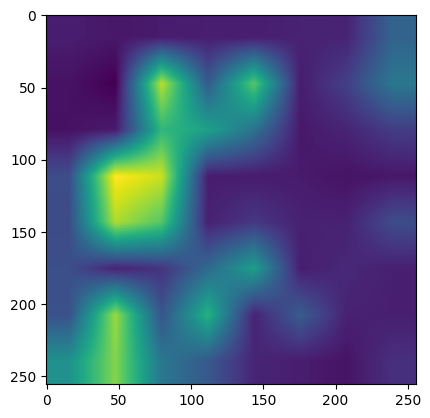

In [277]:
import matplotlib.pyplot as plt
plt.imshow(attn_heatmap_resized[0][0].detach().cpu().numpy())

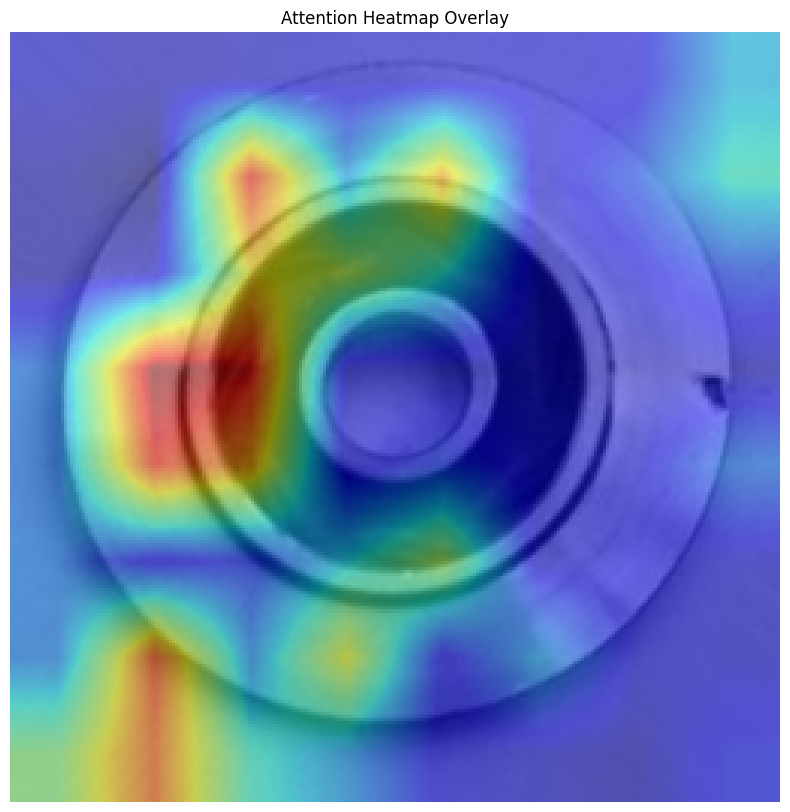

In [278]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T

batch, layers, heads, patch_x, patch_y = attns.shape



# attn_image = T.functional.resize(
#     torch.tensor(attn_combined).unsqueeze(0),  
#     (image_size, image_size),
#     interpolation=T.InterpolationMode.BILINEAR
# )
# attn_image = attn_image.squeeze().numpy()
attn_image = attn_heatmap_resized[0][0].numpy()

img_np = img[0].permute(1, 2, 0).numpy()

img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.imshow(attn_image, cmap='jet', alpha=0.5)  
plt.axis('off')
plt.title("Attention Heatmap Overlay")
plt.show()